In [17]:
import sqlite3
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from os import path
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import findspark
findspark.init()

In [18]:
spark = SparkSession.builder.enableHiveSupport().appName('YelpSentimentalAnalysis').getOrCreate()
sc = spark.sparkContext
sc.defaultParallelism

24

## 1. Data Preparation

In [19]:
df_business = spark.read.json("yelp_academic_dataset_business.json")
df_checkin = spark.read.json("yelp_academic_dataset_checkin.json")
df_review = spark.read.json("yelp_academic_dataset_review.json")
df_tip = spark.read.json("yelp_academic_dataset_tip.json")
df_user = spark.read.json("yelp_academic_dataset_user.json")

In [20]:
df_business = df_business.withColumnRenamed('stars', 'business_stars')
df_review = df_review.withColumnRenamed('stars', 'review_stars')
df_review = df_review.withColumnRenamed('business_id', 'review_business_id')
columns_to_drop = ['address','postal_code','latitude','longitude','review_count']
df_business = df_business.drop(*columns_to_drop)
df_business = df_business.filter(df_business.categories.contains('Restaurants'))

In [21]:
df_business = df_business.withColumnRenamed('name', 'business_name')

In [22]:
df_review.show(5)

+--------------------+----+-------------------+-----+--------------------+------------+--------------------+------+--------------------+
|  review_business_id|cool|               date|funny|           review_id|review_stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+------------+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|         3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|         5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|         3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|         5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:

In [23]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer,StringIndexer,CountVectorizer
import pyspark.mllib.classification
from pyspark.sql.functions import udf
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
import string
import re
import nltk

In [24]:
business_restaurant = df_business.select('business_id', 'categories')


# Get all useful reviews, i.e. a review with at least one useful vote and 
# here we are excluding all neutral reviews as well
review_useful = df_review.select('review_business_id', 'review_id', 'review_stars', 
                              'text', 'useful', 'user_id') \
                      .where("useful >= 1 and stars != 3")


# Join the two dataframes above to get all useful reviews for restaurant businesses
restaurant_useful_review = business_restaurant.join(review_useful, 
                                                    [business_restaurant.business_id == review_useful.review_business_id], 
                                                    how = 'inner')

In [25]:
restaurant_useful_review.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+--------------------+------+--------------------+
|         business_id|          categories|  review_business_id|           review_id|review_stars|                text|useful|             user_id|
+--------------------+--------------------+--------------------+--------------------+------------+--------------------+------+--------------------+
|kxX2SOes4o-D3ZQBk...|Halal, Pakistani,...|kxX2SOes4o-D3ZQBk...|AqPFMleE6RsU23_au...|         5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|Sandwiches, Beer,...|e4Vwtrqf-wpJfwesg...|Sx8TMOWLNuJBWer-0...|         4.0|Cute interior and...|     1|bcjbaE6dDog4jkNY9...|
|04UD14gamNjLY0IDY...|Mediterranean, Re...|04UD14gamNjLY0IDY...|JrIxlS1TzJ-iCu79u...|         1.0|I am a long term ...|     1|eUta8W_HdHMXPzLBB...|
|LHSTtnW3YHCeUkRDG...|Beer Bar, Bars, A...|LHSTtnW3YHCeUkRDG...|_ZeMknuYdlQcUqng_...|         5.0|Amazingly amaz

In [26]:
def convert_rating(rating):
    if rating >=4:
        return 1
    else:
        return 0
rating_convert = udf(lambda x: convert_rating(x))

In [27]:
#remove punctuations
def lower_clean_str(x):
    punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    lowercased_str = x.lower()
    for ch in punc:
        lowercased_str = lowercased_str.replace(ch, '')
    return lowercased_str

punct_remover = udf(lambda x: lower_clean_str(x))

In [28]:
#remove punctuation and lower 
df_word = restaurant_useful_review.select('*', punct_remover('text')).drop('text')
df_word = df_word.withColumnRenamed('<lambda>(text)', 'text')

In [29]:
df_word.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+------+--------------------+--------------------+
|         business_id|          categories|  review_business_id|           review_id|review_stars|useful|             user_id|                text|
+--------------------+--------------------+--------------------+--------------------+------------+------+--------------------+--------------------+
|kxX2SOes4o-D3ZQBk...|Halal, Pakistani,...|kxX2SOes4o-D3ZQBk...|AqPFMleE6RsU23_au...|         5.0|     1|_7bHUi9Uuf5__HHc_...|wow  yummy differ...|
|e4Vwtrqf-wpJfwesg...|Sandwiches, Beer,...|e4Vwtrqf-wpJfwesg...|Sx8TMOWLNuJBWer-0...|         4.0|     1|bcjbaE6dDog4jkNY9...|cute interior and...|
|04UD14gamNjLY0IDY...|Mediterranean, Re...|04UD14gamNjLY0IDY...|JrIxlS1TzJ-iCu79u...|         1.0|     1|eUta8W_HdHMXPzLBB...|i am a long term ...|
|LHSTtnW3YHCeUkRDG...|Beer Bar, Bars, A...|LHSTtnW3YHCeUkRDG...|_ZeMknuYdlQcUqng_...|         5.0|     2|yfFzsLm

## Possible Word Cloud

## 2. Sentimental Analysis by NLP

In [30]:
df_NLP =df_word.select('*',rating_convert('review_stars'))
df_NLP = df_NLP.withColumnRenamed('<lambda>(review_stars)', 'label')
df_NLP.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+------+--------------------+--------------------+-----+
|         business_id|          categories|  review_business_id|           review_id|review_stars|useful|             user_id|                text|label|
+--------------------+--------------------+--------------------+--------------------+------------+------+--------------------+--------------------+-----+
|kxX2SOes4o-D3ZQBk...|Halal, Pakistani,...|kxX2SOes4o-D3ZQBk...|AqPFMleE6RsU23_au...|         5.0|     1|_7bHUi9Uuf5__HHc_...|wow  yummy differ...|    1|
|e4Vwtrqf-wpJfwesg...|Sandwiches, Beer,...|e4Vwtrqf-wpJfwesg...|Sx8TMOWLNuJBWer-0...|         4.0|     1|bcjbaE6dDog4jkNY9...|cute interior and...|    1|
|04UD14gamNjLY0IDY...|Mediterranean, Re...|04UD14gamNjLY0IDY...|JrIxlS1TzJ-iCu79u...|         1.0|     1|eUta8W_HdHMXPzLBB...|i am a long term ...|    0|
|LHSTtnW3YHCeUkRDG...|Beer Bar, Bars, A...|LHSTtnW3YHCeUkRDG...|_ZeMknuYdlQc

In [31]:
#tokenize words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
#remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# Build the pipeline 
pipeline = Pipeline(stages=[tokenizer,remover])
# Fit the pipeline 
df_NLP = pipeline.fit(df_NLP).transform(df_NLP)

## 2.1 Hashing-TF

1). Data Manipulation

In [32]:
# #Maps a sequence of terms to their term frequencies using the hashing trick. 
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
# Build the pipeline 
pipeline = Pipeline(stages=[hashingTF,idf])
# Fit the pipeline 
encodedData_hasingTF = pipeline.fit(df_NLP).transform(df_NLP)

In [33]:
encodedData_hasingTF.show(5)

+--------------------+--------------------+--------------------+--------------------+------------+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|         business_id|          categories|  review_business_id|           review_id|review_stars|useful|             user_id|                text|label|               words|            filtered|         rawFeatures|            features|
+--------------------+--------------------+--------------------+--------------------+------------+------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|kxX2SOes4o-D3ZQBk...|Halal, Pakistani,...|kxX2SOes4o-D3ZQBk...|AqPFMleE6RsU23_au...|         5.0|     1|_7bHUi9Uuf5__HHc_...|wow  yummy differ...|    1|[wow, , yummy, di...|[wow, , yummy, di...|(1000,[86,251,267...|(1000,[86,251,267...|
|e4Vwtrqf-wpJfwesg...|Sandwiches, Beer,...|e4Vwt

In [34]:
#drop the redundant source column
#columns_to_drop = ['business_id','date','review_id','words','text']
encodedData_tf = encodedData_hasingTF.select('review_id','words','features','review_stars')
encodedData_tf.select('review_id','words','features','review_stars').limit(5).toPandas()

,review_id,words,features,review_stars
0,AqPFMleE6RsU23_auESxiA,"[wow, , yummy, different, , delicious, , , our...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.0
1,Sx8TMOWLNuJBWer-0pcmoA,"[cute, interior, and, owner, , gave, us, tour,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.0
2,JrIxlS1TzJ-iCu79ul40cQ,"[i, am, a, long, term, frequent, customer, of,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
3,_ZeMknuYdlQcUqng_Im3yg,"[amazingly, amazing, wings, and, homemade, ble...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.0
4,LnGZB0fjfgeVDVz5IHuEVA,"[the, hubby, and, i, have, been, here, on, mul...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.418...",4.0


In [35]:
encodedData_tf.groupby('review_stars').count().show()

+------------+------+
|review_stars| count|
+------------+------+
|         1.0|264847|
|         4.0|497338|
|         2.0|193798|
|         5.0|773235|
+------------+------+



In [36]:
DF_sa =encodedData_tf.select(rating_convert('review_stars'),'features')
DF_sa = DF_sa.withColumnRenamed('<lambda>(review_stars)', 'label')

In [37]:
#convert classification from string to integer to enable model to run
from pyspark.sql import types 
DF_sa = DF_sa.withColumn("label",DF_sa["label"].cast('int'))

In [38]:
dataset_size=float(DF_sa.select("label").count())
numPositives=DF_sa.select("label").where('label == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 1270573
Percentage of ones are 73.47673919656168


In [39]:
DF_sa = DF_sa.sample(fraction=0.3)

2). Modeling

**Since our dataset is large, we don't need more percentage of data for testing. So we keep only 5% data for testing and 95% data for training the models to achieve higher accuracy.**

In [40]:
splits = DF_sa.randomSplit([0.7, 0.3],seed=100)
train_df_tf = splits[0]
test_df_tf = splits[1]

### Logistic Regression

In [25]:
from pyspark.ml.classification import LogisticRegression

# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lgr_tf = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='label')

# Fit the model to the data.
lgModel_tf = lgr_tf.fit(train_df_tf)

# Given a dataset, predict each point's label, and show the results.
lgr_pred_tf = lgModel_tf.transform(test_df_tf)

In [26]:
lgr_pred_tf.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(1000,[0,1,2,15,3...|[3.24481735519824...|[0.96248643440576...|       0.0|
|    0|(1000,[0,1,5,9,10...|[11.6486777434266...|[0.99999126948741...|       0.0|
|    0|(1000,[0,1,6,9,10...|[11.6349714538188...|[0.99999114900171...|       0.0|
|    0|(1000,[0,1,7,15,1...|[-0.9504026307888...|[0.27880385688227...|       1.0|
|    0|(1000,[0,1,7,15,2...|[-2.5798734376228...|[0.07044501806534...|       1.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(lgr_pred_tf, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(lgr_pred_tf, {evaluator.metricName: "f1"}))

0.9000656024491581
0.8972808496131066


areaUnderROC: 0.9512665755220779


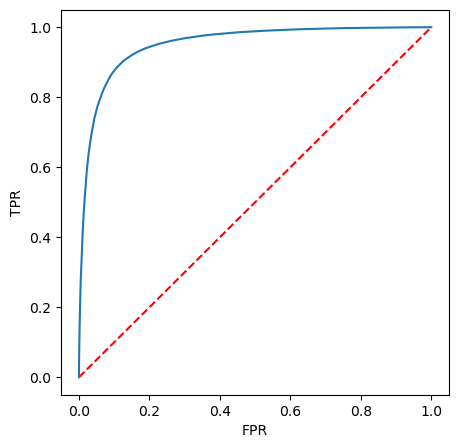

In [28]:
trainingSummary = lgModel_tf.summary

print("areaUnderROC: " + str(trainingSummary.areaUnderROC))
#import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lgModel_tf.summary.roc.select('FPR').collect(),
         lgModel_tf.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
y_true = lgr_pred_tf.select("label").toPandas()
y_pred = lgr_pred_tf.select("prediction").toPandas()

In [31]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels = [1, 0])

In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80     41580
           1       0.91      0.96      0.93    113902

    accuracy                           0.90    155482
   macro avg       0.89      0.85      0.87    155482
weighted avg       0.90      0.90      0.90    155482



## Random Forest

In [41]:
from pyspark.ml.classification import RandomForestClassifier

rf_tf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
# Fit the model to the data.
rfModel_tf = rf_tf.fit(train_df_tf)

# Given a dataset, predict each point's label, and show the results.
rf_pred_tf = rfModel_tf.transform(test_df_tf)

In [42]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(rf_pred_tf, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(rf_pred_tf, {evaluator.metricName: "f1"}))

0.7414808676828603
0.6390047743348624


areaUnderROC: 0.8373196287345285


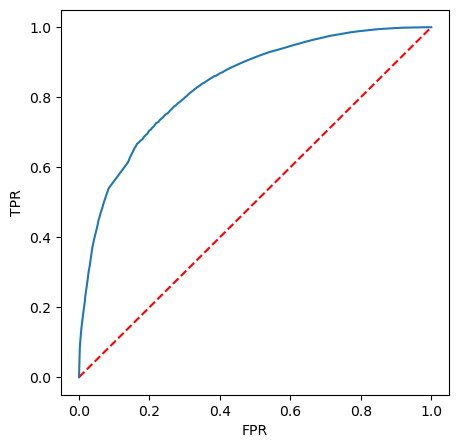

In [43]:
trainingSummary = rfModel_tf.summary

print("areaUnderROC: " + str(trainingSummary.areaUnderROC))
#import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(rfModel_tf.summary.roc.select('FPR').collect(),
         rfModel_tf.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [47]:
from sklearn.metrics import classification_report, confusion_matrix

In [48]:
y_true = rf_pred_tf.select("label").toPandas()
y_pred = rf_pred_tf.select("prediction").toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred, labels = [1, 0])

In [49]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.03      0.06     41421
           1       0.74      1.00      0.85    114258

    accuracy                           0.74    155679
   macro avg       0.86      0.51      0.45    155679
weighted avg       0.80      0.74      0.64    155679



## Gradient Boost Classifier

In [39]:
from pyspark.ml.classification import GBTClassifier
gbt_tf = GBTClassifier(maxIter=10,featuresCol = 'features', labelCol='label')
gbtModel_tf = gbt_tf.fit(train_df_tf)
gbt_pred_tf = gbtModel_tf.transform(test_df_tf)
gbt_pred_tf.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(1000,[0,1,2,15,3...|[-0.0539503449835...|[0.47305096874310...|       1.0|
|    0|(1000,[0,1,5,9,10...|[1.02466149790863...|[0.88587919333853...|       0.0|
|    0|(1000,[0,1,6,9,10...|[-0.0056448736496...|[0.49717759315337...|       1.0|
|    0|(1000,[0,1,7,15,1...|[-0.1002736729371...|[0.45003052921126...|       1.0|
|    0|(1000,[0,1,7,15,2...|[0.05785917899818...|[0.52889735028872...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [44]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(gbt_pred_tf, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(gbt_pred_tf, {evaluator.metricName: "f1"}))

0.810781955467514
0.7848317041383829


In [46]:
y_true = gbt_pred_tf.select("label").toPandas()
y_pred = gbt_pred_tf.select("prediction").toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred, labels = [1, 0])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.38      0.52     41580
           1       0.81      0.97      0.88    113902

    accuracy                           0.81    155482
   macro avg       0.81      0.67      0.70    155482
weighted avg       0.81      0.81      0.78    155482



**This can be used for user's experience prediction. If the predicted value is 0, we can send them a follow-up questionaire and ask them to rate and comment our service.**